# Face Recognition: PCA vs Deep CNN Features

Imports

In [12]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from PIL import Image

 Data Loading




In [13]:
faces = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

print(faces.images.shape)
print(faces.target.shape)

(1288, 50, 37)
(1288,)


Deep Feature Extraction

In [14]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

model.eval()

print("Model loaded successfully!")

Model loaded successfully!


In [15]:
feature_extractor = nn.Sequential(*list(model.children())[:-1])

feature_extractor.eval()

print("feature_extatctor is reday")

feature_extatctor is reday


In [16]:
transform = transforms.Compose([

    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [17]:
sample_face = faces.images[0]
sample_face = Image.fromarray((sample_face * 255).astype(np.uint8))

sample_face = sample_face.convert("RGB")

input_tensor = transform(sample_face)
input_tensor = input_tensor.unsqueeze(0)

print(input_tensor.shape)

torch.Size([1, 3, 224, 224])


In [18]:
with torch.no_grad():
  features = feature_extractor(input_tensor)

print("Feature shape:",features.shape)

Feature shape: torch.Size([1, 512, 1, 1])


In [19]:
feature_vector = features.view(features.size(0), -1)
print("Feature vector shape:",feature_vector.shape)

feature_vector = feature_vector.squeeze(0)
print("Feature vector shape:",feature_vector.shape)

Feature vector shape: torch.Size([1, 512])
Feature vector shape: torch.Size([512])


In [20]:
all_features = []
all_labels = []

batch_size = 32

for i in range(0, len(faces.images), batch_size):
    batch_images = faces.images[i:i+batch_size]
    batch_labels = faces.target[i:i+batch_size]

    processed_images = []

    for img in batch_images:
        img = Image.fromarray((img * 255).astype(np.uint8))
        img = img.convert("RGB")
        img = transform(img)
        processed_images.append(img)

    batch_tensor = torch.stack(processed_images)

    with torch.no_grad():
        features = feature_extractor(batch_tensor)

    features = features.view(features.size(0), -1)

    all_features.append(features)
    all_labels.append(torch.tensor(batch_labels))

all_features = torch.cat(all_features)
all_labels = torch.cat(all_labels)

print("Final feature matrix shape:", all_features.shape)


Final feature matrix shape: torch.Size([1288, 512])


Deep Pipeline

In [21]:
X = all_features.numpy()
y = all_labels.numpy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

svm = SVC(kernel='rbf', C=10, gamma='scale')

svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("Test Accuracy:", acc)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.8881987577639752

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.79      0.88        19
           1       0.90      0.90      0.90        59
           2       0.92      0.80      0.86        30
           3       0.88      0.98      0.93       133
           4       0.72      0.78      0.75        27
           5       1.00      0.72      0.84        18
           6       0.91      0.83      0.87        36

    accuracy                           0.89       322
   macro avg       0.91      0.83      0.86       322
weighted avg       0.89      0.89      0.89       322



In [22]:
svm_linear = SVC(kernel='linear', C=10)
scores_linear = cross_val_score(svm_linear, X, y, cv=5)

print("Linear SVM Mean:", scores_linear.mean())
print("Linear SVM Std:", scores_linear.std())

Linear SVM Mean: 0.8905378095496637
Linear SVM Std: 0.018215188727888767


In [23]:
svm_cv = SVC(kernel='rbf', C=10, gamma='scale')

scores = cross_val_score(svm_cv, X, y, cv=5)

print("Deep Features CV Accuracy:", scores)
print("Mean:", np.mean(scores))
print("Std:", np.std(scores))

Deep Features CV Accuracy: [0.87984496 0.91860465 0.88372093 0.91050584 0.88326848]
Mean: 0.8951889723403614
Std: 0.01607453320886958


PCA Baseline

In [24]:
X_pixels = faces.images.reshape(len(faces.images), -1)
y_pixels = faces.target

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_pixels, y_pixels,
    test_size=0.25,
    random_state=42,
    stratify=y_pixels
)

pca = PCA(n_components=150)
X_train_pca = pca.fit_transform(X_train_pca)
X_test_pca = pca.transform(X_test_pca)

scaler_pca = StandardScaler()
X_train_pca = scaler_pca.fit_transform(X_train_pca)
X_test_pca = scaler_pca.transform(X_test_pca)

svm_pca = SVC(kernel='rbf', C=10, gamma='scale')
svm_pca.fit(X_train_pca, y_train_pca)

y_pred_pca = svm_pca.predict(X_test_pca)

print("PCA Test Accuracy:", accuracy_score(y_test_pca, y_pred_pca))


PCA Test Accuracy: 0.8416149068322981


In [25]:
pca_linear_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=150)),
    ('svm', SVC(kernel='linear', C=10))
])

scores_pca_linear = cross_val_score(pca_linear_pipeline, X_pixels, y_pixels, cv=5)

print("PCA + Linear Mean:", scores_pca_linear.mean())
print("PCA + Linear Std:", scores_pca_linear.std())


PCA + Linear Mean: 0.8167677133291104
PCA + Linear Std: 0.003035495397876144


In [26]:
pca_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=150)),
    ('svm', SVC(kernel='rbf', C=10, gamma='scale'))
])

scores_pca = cross_val_score(pca_pipeline, X_pixels, y_pixels, cv=5)

print("PCA CV Accuracy:", scores_pca)
print("Mean:", np.mean(scores_pca))
print("Std:", np.std(scores_pca))


PCA CV Accuracy: [0.84496124 0.84883721 0.79457364 0.82490272 0.84435798]
Mean: 0.831526558682472
Std: 0.0202691278497494


Visualizations

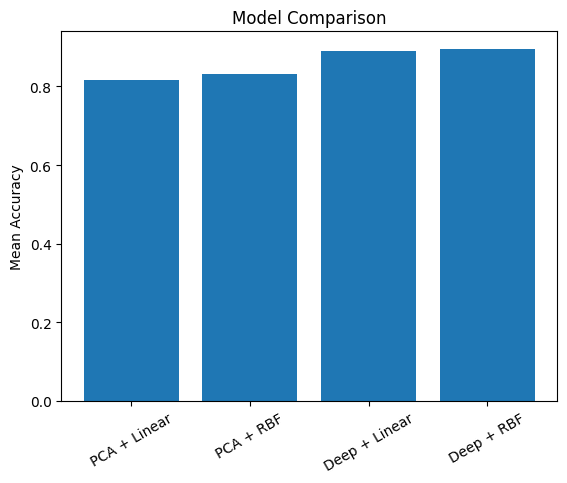

In [30]:
# Bar Plot:

methods = [
    "PCA + Linear",
    "PCA + RBF",
    "Deep + Linear",
    "Deep + RBF"
]

means = [
    scores_pca_linear.mean(),
    scores_pca.mean(),
    scores_linear.mean(),
    scores.mean()
]

plt.figure()
plt.bar(methods, means)
plt.xticks(rotation=30)
plt.ylabel("Mean Accuracy")
plt.title("Model Comparison")
plt.show()


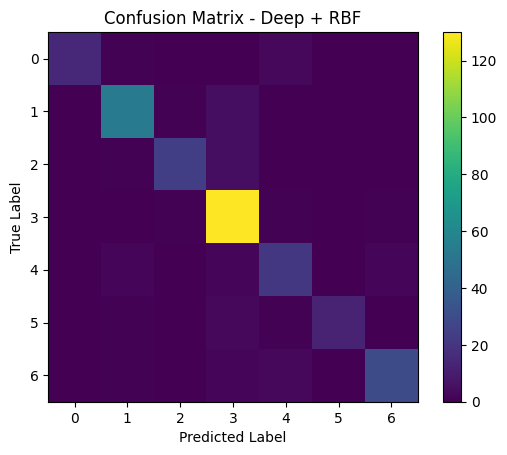

In [31]:
# Confusion matrix for best model (Deep + RBF)

cm = confusion_matrix(y_test, y_pred)

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix - Deep + RBF")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.colorbar()
plt.show()


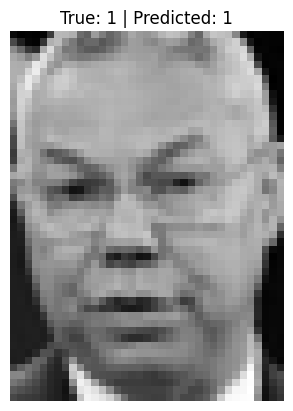

In [32]:
# Example Prediction

sample_index = 0

sample_image = X_test[sample_index]
true_label = y_test[sample_index]
predicted_label = svm.predict(sample_image.reshape(1, -1))[0]

original_image = faces.images[
    np.where(faces.target == true_label)[0][0]
]

plt.figure()
plt.imshow(original_image, cmap='gray')
plt.title(f"True: {true_label} | Predicted: {predicted_label}")
plt.axis('off')
plt.show()
